In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


512 HRV data per (future) CSV
Lower threshold for outliers of 500
Higher threshold for outliers of 2000

In [ ]:
data_per_csv = 512
l_th = 500
h_th = 2000

Access data path

In [ ]:
def dataPath(c):
  if c=='d':
    return 'gdrive/My Drive/Summer Research/HRV/Diabetes/'
  elif c=='h':
    return 'gdrive/My Drive/Summer Research/HRV/Healthy/'
  else:
    raise ValueError('Parameter must be h or d')

train_data_path = 'gdrive/My Drive/Summer Research/HRV/Outlier Free'

New data path (to store the new CSVs)

In [ ]:
def newDataPath(c):
  if c=='d':
    return 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Diabetes/'
  elif c=='h':
    return 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Healthy/'
  else:
    raise ValueError('Parameter must be h or d')

Returns array of DataFrames for each of the CSVs for each individual

In [ ]:
def HRV_DataFrame(c,num):
  data_path = dataPath(c)+str(f'{num:03d}')+'/'
  df = []
  for files in os.listdir(data_path):
    if files.endswith('.csv'):
      s = pd.read_csv(data_path+files)
      if s.empty == False:
        s = pd.read_csv(data_path+files,usecols=[1],skiprows=[0])
        df.append(s)
  return df

Plots HRV values for each individual

In [ ]:
def plotHRV(c,num):
  df = HRV_DataFrame(c,num)
  plt.figure(figsize=(16,9))
  for i in range(len(df)):
    plt.plot(df[i], label=str(i+1), linewidth=2)
  plt.title('CGM Prediction')
  plt.xlabel('HRV Interval')
  plt.ylabel('R to R (ms)')
  plt.legend()

Returns array of lists; detectOutliers[i][j] returns the jth value in the ith list

In [ ]:
def detectOutliers(c,num,lower_threshold,higher_threshold):
  dfs = HRV_DataFrame(c,num)
  o = []
  for csv_num in range(len(dfs)):
    df = dfs[csv_num]
    p = list()
    for i in range(len(df)):
      if df.iloc[i][0] < lower_threshold or df.iloc[i][0] > higher_threshold:
        p.append(i)
    o.append(p)
  return o

Returns the start and length of outlier-free intervals

In [ ]:
def outlierFreeIntervalLengths(c,num,lower_threshold,higher_threshold):
  dfs = detectOutliers(c,num,lower_threshold,higher_threshold)
  p = list()
  for csv_num in range(len(dfs)):
    df = dfs[csv_num]
    o = np.zeros((len(df)-1,2))
    for i in range(len(df)-1):
      o[i,0] = int(df[i]+1)
      o[i,1] = int((df[i+1]-df[i]))
    p.append(o)
  return p

Create folder structure

In [ ]:
def folderStructure():
  for i in range(9):
    try:
      s = newDataPath('d')+f'{(i+1):03d}'+'/'
      os.mkdir(s)
    except OSError as error:
      continue
  for i in range(20):
    try:
      s = ''
      if i == 11:
        s = newDataPath('h')+f'{(i+1):03d}'+'_diabetes/'
      else:
        s = newDataPath('h')+f'{(i+1):03d}'+'/'
      os.mkdir(s)
    except OSError as error:
      continue

In [ ]:
folderStructure()

Put the outlier-free intervals into equal-length CSVs

In [ ]:
def outlierFreeToCSV(c,num,lower_threshold,higher_threshold):
  interval_length = outlierFreeIntervalLengths(c,num,lower_threshold,higher_threshold)
  csvs = HRV_DataFrame(c,num)
  dir = ''
  if c == 'h' and num == 12:
    dir = f'{num:03d}' + '_diabetes/'
  else:
    dir = f'{num:03d}' + '/'
  count = 0
  for i in range(len(interval_length)):
    #access each array in the list
    a = interval_length[i]
    for j in range(len(a)):
      if a[j,1] >= data_per_csv:
        length = int(a[j,1] / data_per_csv)
        for k in range(length):
          count += 1
          location = newDataPath(c)+dir+f'{count:03d}'+'.csv'
          start = int(a[j,0]) + k*data_per_csv
          end = int(a[j,0]) + (k+1)*data_per_csv
          new_csv = csvs[i].loc[range(start,end),:]
          new_csv.to_csv(location, index=False, header=False)

In [ ]:
for i in range(9):
  outlierFreeToCSV('d',i+1,l_th,h_th)

In [ ]:
for i in range(20):
  outlierFreeToCSV('h',i+1,l_th,h_th)

Wavelet Transformed data path (to store the new new CSVs)

In [ ]:
def WTDataPath(c):
  if c=='d':
    return 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Wavelet Transformed Data/Diabetes/'
  elif c=='h':
    return 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Wavelet Transformed Data/Healthy/'
  else:
    raise ValueError('Parameter must be h or d')

In [ ]:
def WTDenoisedDataPath(c):
  if c=='d':
    return 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Wavelet Transform Denoised Data/Diabetes/'
  elif c=='h':
    return 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Wavelet Transform Denoised Data/Healthy/'
  else:
    raise ValueError('Parameter must be h or d')

Wavelet Transform

In [ ]:
def fourWTM(n):
  #Filter banks
  h0 = np.array([0.2697890,0.3947890,0.5197890,0.6447890,0.2302110,0.1052110,-0.0197890,-0.1447890])
  h1 = np.array([-0.2825435,0.5553379,0.2385187,-0.0783004, -0.5834819,-0.2666627,0.0501564,0.3669755])
  h2 = np.array([0.4125840,-0.6279376,0.3727824,0.1487574, -0.4125840,-0.1885590,0.0354659,0.2594909])
  h3 = np.array([0.2382055,0.1088646,-0.7275830,0.5572896, -0.2382055,-0.1088646,0.0204763,0.1498171])
  #Matrix of filter banks created for convenience
  h = np.array([h0,h1,h2,h3])

  k = int(n/4)
  T = np.zeros((n,n))
  for j in range(4):
    for i in range(k):
      if 4*i+8 > 4*k:
        T[k*j+i,range((4*i),(4*i+4))] = h[j,range(4)]
        T[k*j+i,range(4)] = h[j,range(4,8)]
      else:
        T[k*j+i,range((4*i),(4*i+8))] = h[j,range(8)]
  return T

In [ ]:
def four_Wavelet_Transform_Decomp(c,num):
  n = data_per_csv
  hrv = New_HRV_Arrays(c,num)
  t = fourWTM(n)
  #S tilda pseudoimage
  s = np.zeros((len(hrv),data_per_csv,4))

  for j in range(len(hrv)):
    ts = np.matmul(t,hrv[j])

    a1, d1, d2, d3 = ts[0:int(n/4)], ts[int(n/4):int(n/2)], ts[int(n/2):int(3*n/4)], ts[int(3*n/4):n]

    dim = int(n/4)
    A1 = np.zeros((4*dim,1))
    D1 = np.zeros((4*dim,1))
    D2 = np.zeros((4*dim,1))
    D3 = np.zeros((4*dim,1))

    for i in range(dim):
      A1 = A1 + a1[i]*np.transpose(t[i:(i+1),:])

    for i in range(dim):
      D1 = D1 + d1[i]*np.transpose(t[i+dim:(i+dim+1),:])
  
    for i in range(dim):
      D2 = D2 + d2[i]*np.transpose(t[i+2*dim:(i+2*dim+1),:])

    for i in range(dim):
      D3 = D3 + d3[i]*np.transpose(t[i+3*dim:(i+3*dim+1),:])

    s[j,:,:] = np.concatenate((A1,D1,D2,D3),axis=1)
  return s

In [ ]:
def four_Wavelet_Transform_Decomp_Denoised(c,num):
  n = data_per_csv
  dim = int(n/4)
  t = fourWTM(n)
  tt = np.transpose(t)
  d = np.zeros((dim,3))
  D = np.zeros((n,3))
  dir = WTDataPath(c)+f'{num:03d}'+'/'
  num_of_csv = len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))])
  #S tilda pseudoimage
  s = np.zeros((num_of_csv,data_per_csv,4))
  signal = np.zeros((data_per_csv,4))
    
  for k in range(num_of_csv):
    sig = np.loadtxt(dir+f'{(k+1):03d}'+'.csv', delimiter=',')
    A1 = sig[:,0].reshape(-1,1)
    for j in range(3):
      d[:,j] = np.matmul(t[(j+1)*dim:(j+2)*dim,:],sig[:,j+1])

      #Denoise details
      lbda = np.std(d[:,j])*math.sqrt(2*math.log(n/4))
      for i in range(dim):
        if abs(d[i,j]) < lbda:
          d[i,j] = 0
      D[:,j] = np.matmul(tt[:, (j+1)*dim:(j+2)*dim], d[:,j])
    s[k,:,:] = np.concatenate((A1,D),axis=1)
  return s

In [ ]:
for i in range(9):
  s = four_Wavelet_Transform_Decomp_Denoised('d',i+1)
  for j in range(len(s)):
    np.savetxt(WTDenoisedDataPath('d')+f'{(i+1):03d}'+'/'+f'{(j+1):03d}'+'.csv', s[j], delimiter=',', fmt='%f')

In [ ]:
for i in range(20):
  if i != 11:
    s = four_Wavelet_Transform_Decomp_Denoised('h',i+1)
    for j in range(len(s)):
      np.savetxt(WTDenoisedDataPath('h')+f'{(i+1):03d}'+'/'+f'{(j+1):03d}'+'.csv', s[j], delimiter=',', fmt='%f')

Returns array of DataFrames for each of the CSVs for each individual

In [ ]:
def New_HRV_Arrays(c,num):
  data_path = newDataPath(c)+str(f'{num:03d}')+'/'
  df = []
  count = 0
  for files in os.listdir(data_path):
    if files.endswith('.csv'):
      count += 1
      s = np.loadtxt(data_path+str(f'{count:03d}')+'.csv', delimiter=',').reshape(data_per_csv,1)
      df.append(s)
  return df

Create folder structure

In [ ]:
def WT_FolderStructure():
  for i in range(9):
    try:
      s = WTDataPath('d')+f'{(i+1):03d}'+'/'
      os.mkdir(s)
    except OSError as error:
      continue
  for i in range(20):
    try:
      if i != 11:
        s = WTDataPath('h')+f'{(i+1):03d}'+'/'
        os.mkdir(s)
    except OSError as error:
      continue

In [ ]:
WT_FolderStructure()

In [ ]:
def WTDenoised_FolderStructure():
  for i in range(9):
    try:
      s = WTDenoisedDataPath('d')+f'{(i+1):03d}'+'/'
      os.mkdir(s)
    except OSError as error:
      continue
  for i in range(20):
    try:
      if i != 11:
        s = WTDenoisedDataPath('h')+f'{(i+1):03d}'+'/'
        os.mkdir(s)
    except OSError as error:
      continue

In [ ]:
WTDenoised_FolderStructure()

Put the Wavelet Transformed Pseudo-images into CSVs

In [ ]:
for i in range(9):
  s = four_Wavelet_Transform_Decomp('d',i+1)
  for j in range(len(s)):
    np.savetxt(WTDataPath('d')+f'{(i+1):03d}'+'/'+f'{(j+1):03d}'+'.csv', s[j], delimiter=',', fmt='%f')

In [ ]:
for i in range(20):
  if i != 11:
    s = four_Wavelet_Transform_Decomp('h',i+1)
    for j in range(len(s)):
      np.savetxt(WTDataPath('h')+f'{(i+1):03d}'+'/'+f'{(j+1):03d}'+'.csv', s[j], delimiter=',', fmt='%f')

Graph some HRV data

In [ ]:
def WTPlotHRV(c,num,subnum):
  n = np.loadtxt(newDataPath(c)+str(f'{num:03d}')+'/'+str(f'{subnum:03d}')+'.csv', delimiter=',').reshape(data_per_csv,1)
  wt = np.loadtxt(WTDataPath(c)+str(f'{num:03d}')+'/'+str(f'{subnum:03d}')+'.csv', delimiter=',')
  wt_denoised = np.loadtxt(WTDenoisedDataPath(c)+str(f'{num:03d}')+'/'+str(f'{subnum:03d}')+'.csv', delimiter=',')
  plt.figure(figsize=(32,18))
  plt.plot(n, label=str(num)+':'+str(subnum)+' (Without WT)', linewidth=2)

  wt_dict = {
      0: ['A1',1],
      1: ['D1',0],
      2: ['D2',2],
      3: ['D3',4]
  }

  for i in range(4):
    plt.plot(wt[:,i]-250*(wt_dict[i][1]), label=str(num)+':'+str(subnum)+' ('+wt_dict[i][0]+')', linewidth=1)
    if i != 0:
      plt.plot(wt_denoised[:,i]-250*(wt_dict[i][1]), label=str(num)+':'+str(subnum)+' ('+wt_dict[i][0]+' denoised)', linewidth=2)
  plt.title('HRV Data')
  plt.xlabel('HRV Interval')
  plt.ylabel('R to R (ms)')
  plt.legend()

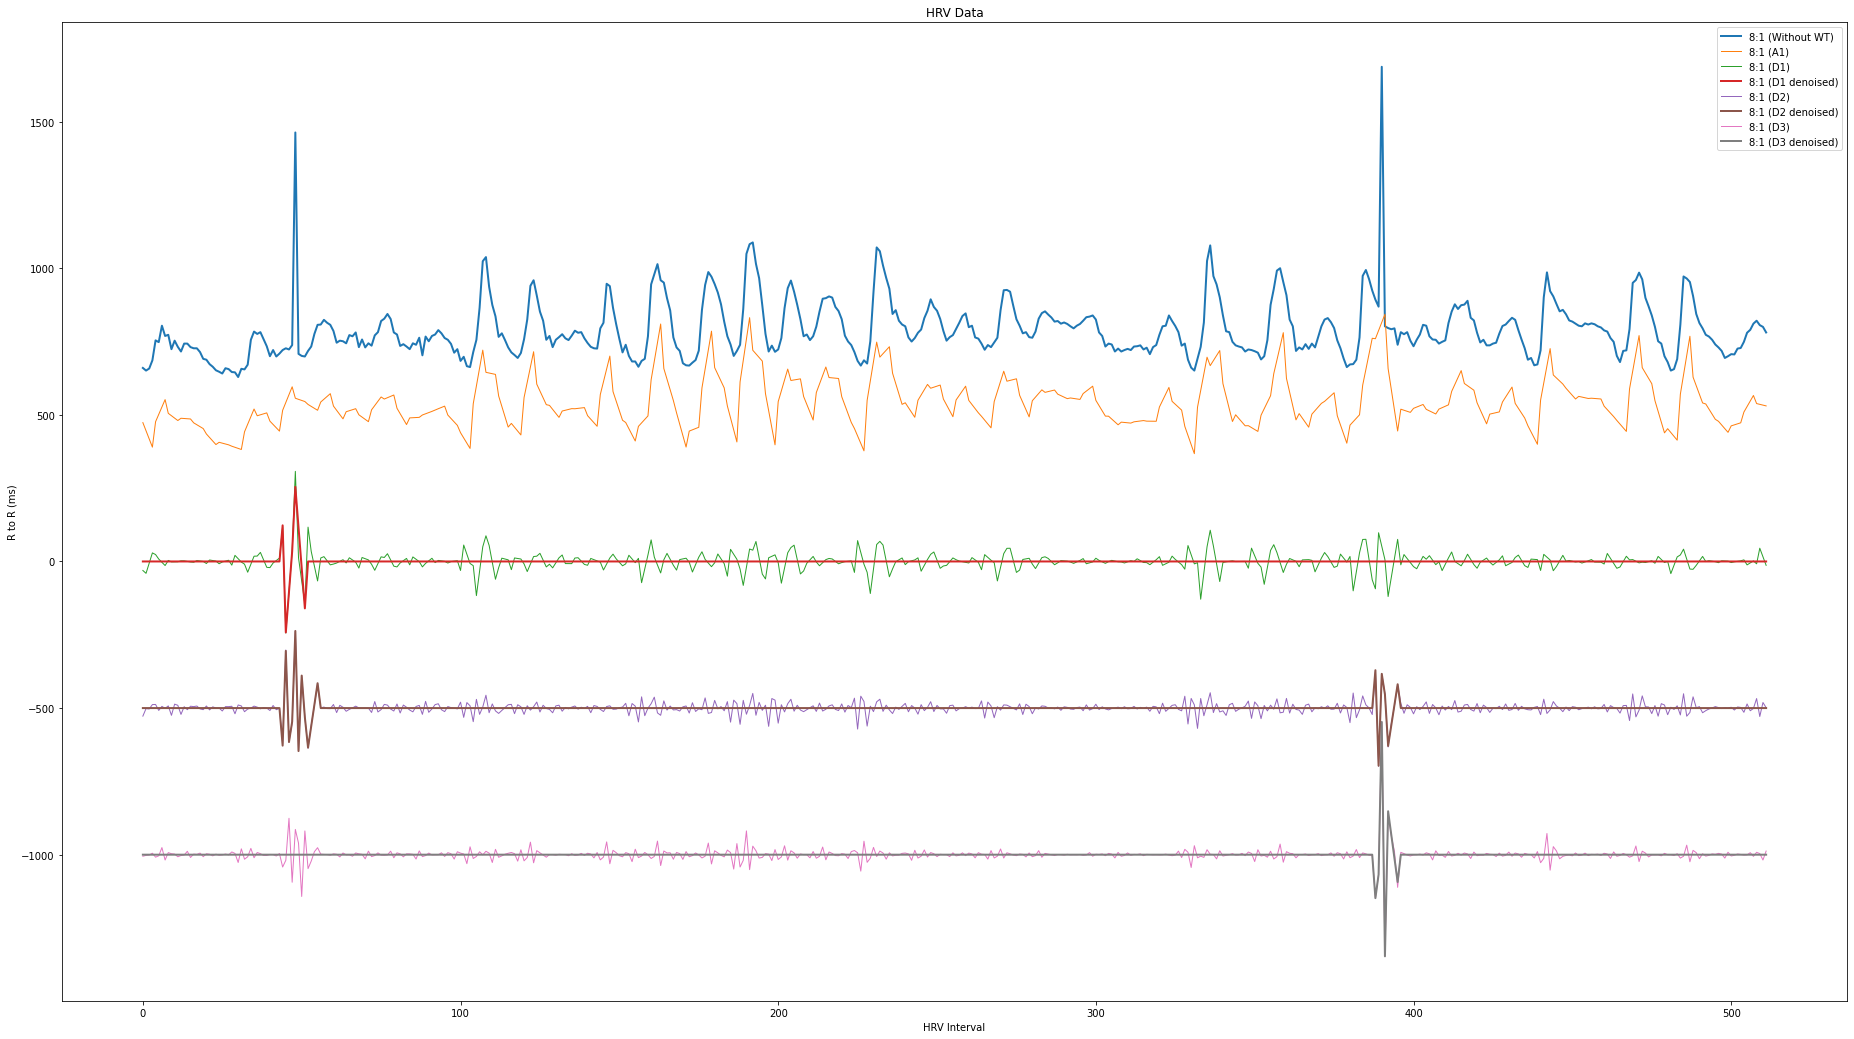

In [ ]:
WTPlotHRV('h',8,1)

Check how much data there is for diabetes, healthy patients

In [ ]:
diabetes_count = 0
healthy_count = 0

for i in range(9):
  dir = WTDataPath('d')+f'{i+1:03d}'+'/'
  for files in os.listdir(dir):
    if files.endswith('.csv'):
      diabetes_count += 1

for i in range(20):
  if i != 11:
    dir = WTDataPath('h')+f'{i+1:03d}'+'/'
    for files in os.listdir(dir):
      if files.endswith('.csv'):
        healthy_count += 1

print('Diabetes: '+str(diabetes_count)+'\nHealthy: '+str(healthy_count))

Diabetes: 769
Healthy: 3003


Convert time series to image

In [ ]:
def HRVImage(c,num,subnum):
  n = np.loadtxt(newDataPath(c)+str(f'{num:03d}')+'/'+str(f'{subnum:03d}')+'.csv', delimiter=',').reshape(data_per_csv,1)
  hd = {
      'd':'Diabetes/',
      'h':'Healthy/'
  }
  plt.figure(figsize=(4,3))
  plt.box(False)
  plt.axis('off')
  bbox_inches=0
  plt.plot(n, linewidth=1, color='black')
  
  plt.margins(0,0)
  plt.savefig('gdrive/My Drive/Summer Research/HRV/Outlier Free/Images/All/'+c+str(num)+'_'+str(subnum),bbox_inches='tight',pad_inches = 0,format='png')
  plt.cla()
  plt.clf()
  plt.close('all')

In [ ]:
for i in range(9):
  count = 0
  dir = WTDataPath('d')+f'{i+1:03d}'+'/'
  for files in os.listdir(dir):
    if files.endswith('.csv'):
      count += 1
      HRVImage('d',i+1,count)

In [ ]:
for i in range(20):
  print(i+1)
  count = 0
  if i != 11:
    dir = WTDataPath('h')+f'{i+1:03d}'+'/'
    for files in os.listdir(dir):
      if files.endswith('.csv'):
        count += 1
        HRVImage('h',i+1,count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Make sure all images are the same size

In [ ]:
from PIL import Image
def sameSize(dir):
  check_size = list()
  for files in os.listdir(dir):
    img = np.array(Image.open(dir+files))
    if img.shape != (163, 223, 4):
      check_size.append(files)
  return check_size

In [ ]:
sameSize('gdrive/My Drive/Summer Research/HRV/Outlier Free/Images/All/')

[]

In [ ]:
diabetes_count = 0

count = 0
dir = 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Images/Diabetes/'
for files in os.listdir(dir):
  if files.endswith('.png'):
    diabetes_count += 1
    count += 1
print(diabetes_count)

769


In [ ]:
healthy_count = 0
count = np.zeros(20)

dir = 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Images/Healthy/'
for files in os.listdir(dir):
  healthy_count += 1
  count[int(files[0])-1] += 1
print(healthy_count)
print(count)